In [ ]:
import os, glob, re, csv
import numpy as np
import nibabel as nib
import statsmodels.api as sm
from nilearn import datasets
from nilearn.image import resample_to_img
import pandas as pd
from scipy.stats import ttest_1samp
from nilearn import plotting, datasets
import scipy.stats as stats
from scipy.optimize import nnls   
from statsmodels.stats.multitest import fdrcorrection


In [2]:
# Load the BOLD cleaned image
bold_img = nib.load('/Volumes/Passport/fmriprep/derivatives/pieMan_cleaned/sub-002/func/sub-002_task-pieman_run-1_cleaned_desc-masked_bold.nii.gz')

# Print voxel size (spatial resolution) and TR (temporal resolution)
zooms = bold_img.header.get_zooms()
print(f"Voxel size (mm): {zooms[:3]}")
print(f"TR (s): {zooms[3]}")
print(f"Shape {bold_img.shape}")

Voxel size (mm): (3.0, 3.0, 4.0)
TR (s): 1.5
Shape (65, 77, 49, 160)


In [3]:
# SET MAIN HYPERPARAMETERS
# TRAIT_LABEL = "Contemplating"  

TRAIT_SETS = {
    "all_13": [
        "Open-minded","feeling Affectionate","Attentive","Assertive",
        "feeling Gloomy","feeling Peaceful","Agreeable","Judging",
        "feeling Angry","feeling Bewildered","Impulsive",
        "Self-disciplined","Contemplating"
    ],
    "mental_8": [
        "feeling Affectionate","feeling Gloomy","feeling Peaceful",
        "feeling Angry","feeling Bewildered","Judging",
        "Contemplating","Attentive"
    ],
    "personality_5": [
        "Open-minded","Agreeable","Assertive",
        "Self-disciplined","Impulsive"
    ],
    "trait_9": [
        "Open-minded","feeling Affectionate","Attentive","Assertive",
        "Agreeable","Judging","feeling Angry","Self-disciplined","Contemplating"
    ]
}

# Select model here: choose one key from TRAIT_SETS
model_key = "trait_9"   # options: all_13, mental_8, personality_5, trait_9
traits    = TRAIT_SETS[model_key]

# ALL_TRAIT_LABELS = [
    #"Open-minded","feeling Affectionate","Attentive","Assertive",
    #"feeling Gloomy","feeling Peaceful","Agreeable","Judging",
    #"feeling Angry","feeling Bewildered","Impulsive",
    #"Self-disciplined","Contemplating"
#]
ALL_TRAIT_SAVE_STRS = [t.replace(" ","_").replace("-","_")
                       for t in traits]
# Our 13 trait labels 
# ["Open-minded", "feeling Affectionate", "Attentive", "Assertive", "feeling Gloomy", "feeling Peaceful", "Agreeable", "Judging", "feeling Angry", "feeling Bewildered", "Impulsive", "Self-disciplined", "Contemplating"]

#TRAIT_LABEL_SAVE_STRING = TRAIT_LABEL.replace(" ", "_").replace("-", "_")
STIMULUS_LABEL_SAVE_STRING = "pieman"

# Set smoothing setting to either use smoothed trait RDMs or the un-smoothed RDMs
smoothing_setting = "_no_smoothing"    # set to _no_smoothing or set to "" for smoothed RDMs

In [4]:
# ──────────────────────────────────────────────────────────────
# 0) PATHS & I/O
# ──────────────────────────────────────────────────────────────
root_dir  = "/Volumes/Passport/fmriprep"          # ←  same as in cleaning script
deriv_dir = os.path.join(root_dir, "derivatives") #   (don’t hard-code “subjects” yet)



# output from your behaviour-model RSA
for trait_long, trait_save in zip(traits, ALL_TRAIT_SAVE_STRS):
    rdm_path = os.path.join(
        deriv_dir, "RDMs_behavior",
        f"{STIMULUS_LABEL_SAVE_STRING}_{trait_save}_RDM{smoothing_setting}.npy"
    )
    model_rdm = np.load(rdm_path)

In [5]:
# ──────────────────────────────────────────────────────────────
# 1) SUBJECT / RUN FILTERS  (copy-paste verbatim)  ─────────────
# ──────────────────────────────────────────────────────────────
exclude_subs = {
    "sub-001","sub-021","sub-022","sub-038","sub-056","sub-068","sub-069"
}
exclude_sub_runs = {
    ("sub-002","2"),("sub-003","2"),("sub-004","2"),("sub-005","2"),("sub-006","2"),
    ("sub-008","2"),("sub-010","2"),("sub-011","2"),("sub-012","2"),("sub-013","2"),
    ("sub-014","2"),("sub-015","2"),("sub-016","2")
}
target_subject = None     # e.g. "sub-002" to run a single person


In [6]:
# ----------------------------------------------------------------
# 2)  BUILD SUBJECT LIST  (from cleaned derivatives)  ------------
# ----------------------------------------------------------------
cleaned_root = os.path.join(deriv_dir, f"{STIMULUS_LABEL_SAVE_STRING}_cleaned")
all_subs     = sorted(
    d for d in os.listdir(cleaned_root) if d.startswith("sub-")
)
if target_subject:
    if target_subject not in all_subs:
        raise ValueError(f"{target_subject} not found in {cleaned_root}")
    subjects = [target_subject]
else:
    subjects = [s for s in all_subs if s not in exclude_subs]

print("Subjects to process →", ", ".join(subjects))

Subjects to process → sub-002, sub-003, sub-004, sub-005, sub-006, sub-007, sub-008, sub-009, sub-010, sub-011, sub-012, sub-013, sub-014, sub-015, sub-016, sub-017, sub-018, sub-019, sub-020, sub-023, sub-024, sub-025, sub-026, sub-027, sub-028, sub-029, sub-030, sub-031, sub-032, sub-033, sub-034, sub-035, sub-036, sub-037, sub-039, sub-040, sub-041, sub-042, sub-043, sub-044, sub-045, sub-046, sub-047, sub-048, sub-049, sub-050, sub-051, sub-052, sub-053, sub-054, sub-055, sub-057, sub-058, sub-059, sub-060, sub-061, sub-062, sub-063, sub-064, sub-065, sub-066, sub-067, sub-070, sub-071, sub-072, sub-073, sub-074, sub-075, sub-076, sub-077, sub-078, sub-079, sub-080, sub-081, sub-082


In [7]:
# ──────────────────────────────────────────────────────────────
# 3) FETCH SCHAEFER ATLAS  ─────────────────────────────────────
# ──────────────────────────────────────────────────────────────

# Schaefer parcel/atlas parameters
n_rois = 200
yeo_networks = 17
resolution_mm = 2                   # resolution of your Schaefer atlas (double check!)

schaefer    = datasets.fetch_atlas_schaefer_2018(
                 n_rois=n_rois,
                 yeo_networks=yeo_networks,
                 resolution_mm=resolution_mm
             )
atlas_img   = nib.load(schaefer['maps'])  # default 2mm MNI - but our images 3x3x4 (Pieman and others) OR 2.5^3 (ie., Black and Forgot)

atlas_resampled = resample_to_img(atlas_img, bold_img, interpolation='nearest')
atlas_data     = atlas_resampled.get_fdata()



# Change Schaeffer Labels so 0 is whole brain and 1 corresponds to 1st ROI
labels = schaefer['labels']
# change to string and remove excess
labels = [l.replace(b'17Networks_', b'').decode('utf-8') for l in labels]
# Prepend background label
labels = np.insert(labels, 0, "Background")

# Multiple Regression

In [8]:
def compute_r2(X, y):
    """
    Compute the coefficient of determination (R²) for a linear regression model.
    Parameters
    ----------"""
    betas, _ = nnls(X, y)
    y_pred = X @ betas
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def permutation_test(X, y, n_permutations=10):

    # compute observed R2
    r2_observed = compute_r2(X, y)
    
    # Permutation test for R² - create null distribution from N permutations
    r2_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        y_permuted = np.random.permutation(y)
        r2_values[i] = compute_r2(X, y_permuted)
    

    # retrurn p-value and pseudo-t value
    pseudo_t = (r2_observed - np.mean(r2_values)) / np.std(r2_values, ddof=1)
    p_value = np.mean(r2_values >= r2_observed)
    return pseudo_t, p_value    


In [9]:


# 1) Load all the single-trait .npy RDMs 
model_rdms = {}
for trait, sstr in zip(traits, ALL_TRAIT_SAVE_STRS):
    filepath = os.path.join(
        deriv_dir, "RDMs_behavior",
        f"{STIMULUS_LABEL_SAVE_STRING}_{sstr}_RDM{smoothing_setting}.npy"
    )
    model_rdms[trait] = np.load(filepath)

# 2) multi-regression RSA 
def rsa_multi_nnls(neural_rdm, model_rdms, traits):
    idx = np.tril_indices(neural_rdm.shape[0], k=-1)
    y   = neural_rdm[idx]
    
    # design matrix of all behavioural RDMs
    Xs  = [model_rdms[t][idx] for t in traits]
    X   = np.column_stack(Xs)              # shape (N, p)
    X   = np.column_stack([np.ones_like(y), X])   # prepend intercept

    # NNLS
    coef, rnorm = nnls(X, y)                   
    #coef, _ = nnls(X, y)                   # coef[0] = intercept
    betas = dict(zip(traits, coef[1:]))

    


    # pseudo-r2 for full model vs null (y̅)
    y_pred = X @ coef
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    r2 = 1 - (ss_res / ss_tot)

    # compute pseudo F-statistic
    p = len(traits) 
    N = len(y)
    ss_reg = ss_tot - ss_res
    f_stat = (ss_reg / p) / (ss_res / (N - p - 1))

    
    # permutation test
    pseudo_t, permutation_p_value = permutation_test(X, y)

    return betas, r2, pseudo_t, permutation_p_value, float(f_stat)

# 3) run multi-regression for each subject 
def run_multi_for_subject(sub):
    func_dir   = os.path.join(cleaned_root, sub, "func")
    run_pat    = os.path.join(
        func_dir,
        f"{sub}_task-{STIMULUS_LABEL_SAVE_STRING}_run-*_*cleaned_desc-masked_bold.nii.gz"
    )
    single_pat = os.path.join(
        func_dir,
        f"{sub}_task-{STIMULUS_LABEL_SAVE_STRING}_cleaned_desc-masked_bold.nii.gz"
    )
    bold_files = sorted(glob.glob(run_pat)) + sorted(glob.glob(single_pat))
    if not bold_files:
        print(f"⏩ {sub}: no runs"); return

    rows = []
    for bf in bold_files:
        m   = re.search(r"_run-(\d+)_", os.path.basename(bf))
        run = m.group(1) if m else "NA"
        if (sub, run) in exclude_sub_runs: continue

        bold_img  = nib.load(bf)
        bold_data = bold_img.get_fdata()
        atlas_res = resample_to_img(atlas_img, bold_img, interpolation="nearest")
        atlas_dat = atlas_res.get_fdata()

        for parcel_id in range(1, n_rois+1):
            print(f"Parcel {parcel_id} of {n_rois}")    
            mask = atlas_dat == parcel_id
            if not mask.any(): continue
            neural_rdm = 1 - np.corrcoef(bold_data[mask,:].T).astype(np.float32)
            betas, r2, pseudo_t, permutation_p_value, f_stat = rsa_multi_nnls(neural_rdm, model_rdms, traits)
            parcel_label = labels[parcel_id]     # ← NEW column
            # build row: sub, run, parcel, β₁…β₁₃, F_stat
            row = [sub, run, parcel_id, parcel_label] + [betas[t] for t in traits] + [r2] + [pseudo_t] + [permutation_p_value]+[float(f_stat)]
            rows.append(row)

    # write out into a new multi_regression folder
    out_base = os.path.join(
        deriv_dir, "RSA_stats",
        STIMULUS_LABEL_SAVE_STRING, "multi_regression", "subject_results"
    )
    os.makedirs(out_base, exist_ok=True)

    header = ["subject","run","parcel_num", "parcel_label"] + ALL_TRAIT_SAVE_STRS + ["r2"] + ["pseudo_t"] + ["permutation_p_value"]+["f_stat"]
    out_csv = os.path.join(
        out_base,
        f"{sub}_{STIMULUS_LABEL_SAVE_STRING}_multi_parcel_RSA_NNLS_{model_key}{smoothing_setting}.csv"
    )
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)

    print(f"✅ {sub} MULTI-REG CSV → {out_csv}")



In [10]:
# 4) callfor each subject
for sub in subjects:
    run_multi_for_subject(sub)
    # break             # comment out to run all subjects

print("ALL MULTI-REG DONE 🎉")

Parcel 1 of 200
Parcel 2 of 200
Parcel 3 of 200
Parcel 4 of 200
Parcel 5 of 200
Parcel 6 of 200
Parcel 7 of 200
Parcel 8 of 200
Parcel 9 of 200
Parcel 10 of 200
Parcel 11 of 200
Parcel 12 of 200
Parcel 13 of 200
Parcel 14 of 200
Parcel 15 of 200
Parcel 16 of 200
Parcel 17 of 200
Parcel 18 of 200
Parcel 19 of 200
Parcel 20 of 200
Parcel 21 of 200
Parcel 22 of 200
Parcel 23 of 200
Parcel 24 of 200
Parcel 25 of 200
Parcel 26 of 200
Parcel 27 of 200
Parcel 28 of 200
Parcel 29 of 200
Parcel 30 of 200
Parcel 31 of 200
Parcel 32 of 200
Parcel 33 of 200
Parcel 34 of 200
Parcel 35 of 200
Parcel 36 of 200
Parcel 37 of 200
Parcel 38 of 200
Parcel 39 of 200
Parcel 40 of 200
Parcel 41 of 200
Parcel 42 of 200
Parcel 43 of 200
Parcel 44 of 200
Parcel 45 of 200
Parcel 46 of 200
Parcel 47 of 200
Parcel 48 of 200
Parcel 49 of 200
Parcel 50 of 200
Parcel 51 of 200
Parcel 52 of 200
Parcel 53 of 200
Parcel 54 of 200
Parcel 55 of 200
Parcel 56 of 200
Parcel 57 of 200
Parcel 58 of 200
Parcel 59 of 200
Parcel

In [11]:


# collect all R2_stats
records = []
pattern = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression", "subject_results", f"*_multi_parcel_RSA_NNLS_{model_key}{smoothing_setting}.csv"
)
for fn in glob.glob(pattern):
    df = pd.read_csv(fn, usecols=["subject","run","parcel_num","r2"])
    # create one row per entry
    df["unit"] = df["subject"] + "_" + df["run"].astype(str)
    records.append(df)
all_f = pd.concat(records, ignore_index=True)

# group‐level t-test per parcel
group_results = []
for parcel, grp in all_f.groupby("parcel_num"):
    t_stat, p_unc = ttest_1samp(grp["r2"], popmean=0, alternative="greater")
    group_results.append((parcel, t_stat, p_unc))

gr = pd.DataFrame(group_results, columns=["parcel_num","t_stat","p_uncorrected"])
# FDR across all parcels
_, p_fdr = fdrcorrection(gr["p_uncorrected"])
gr["p_fdr"] = p_fdr

# add parcel labels
gr["parcel_label"] = labels[1:]  # skip background label

# reorganize columns
gr = gr[["parcel_num","parcel_label","t_stat","p_uncorrected","p_fdr"]]

# save
# save
group_out_dir = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression", "group_results"
)
os.makedirs(group_out_dir, exist_ok=True)

out_group = os.path.join(
    group_out_dir, f"group_R2_stats_with_FDR_NNLS_{model_key}{smoothing_setting}.csv"
)

gr.to_csv(out_group, index=False)
print(f"✅ Saved group‐level R2‐test results → {out_group}")

✅ Saved group‐level R2‐test results → /Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/multi_regression/group_results/group_R2_stats_with_FDR_NNLS_trait_9_no_smoothing.csv


In [12]:


# collect all F_stats
records = []
pattern = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression","subject_results", f"*_multi_parcel_RSA_NNLS_{model_key}{smoothing_setting}.csv"
)
for fn in glob.glob(pattern):
    df = pd.read_csv(fn, usecols=["subject","run","parcel_num","f_stat"])
    # create one row per entry
    df["unit"] = df["subject"] + "_" + df["run"].astype(str)
    records.append(df)
all_f = pd.concat(records, ignore_index=True)

# group‐level t-test per parcel
group_results = []
for parcel, grp in all_f.groupby("parcel_num"):
    t_stat, p_unc = ttest_1samp(grp["f_stat"], popmean=1, alternative="greater")
    group_results.append((parcel, t_stat, p_unc))

gr = pd.DataFrame(group_results, columns=["parcel_num","t_stat","p_uncorrected"])
# FDR across all parcels
_, p_fdr = fdrcorrection(gr["p_uncorrected"])
gr["p_fdr"] = p_fdr

# add parcel labels
gr["parcel_label"] = labels[1:]  # skip background label

# reorganize columns
gr = gr[["parcel_num","parcel_label","t_stat","p_uncorrected","p_fdr"]]

# save
group_out_dir = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression", "group_results"
)
os.makedirs(group_out_dir, exist_ok=True)

out_group = os.path.join(
    group_out_dir, f"group_F1_stats_with_FDR_NNLS_{model_key}{smoothing_setting}.csv"
)
gr.to_csv(out_group, index=False)
print(f"✅ Saved group‐level F‐test results → {out_group}")

✅ Saved group‐level F‐test results → /Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/multi_regression/group_results/group_F1_stats_with_FDR_NNLS_trait_9_no_smoothing.csv


✅ Saved thresholded t-map → /Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/multi_regression/200parcel_t_map_NNLS_trait_9_no_smoothing.nii.gz


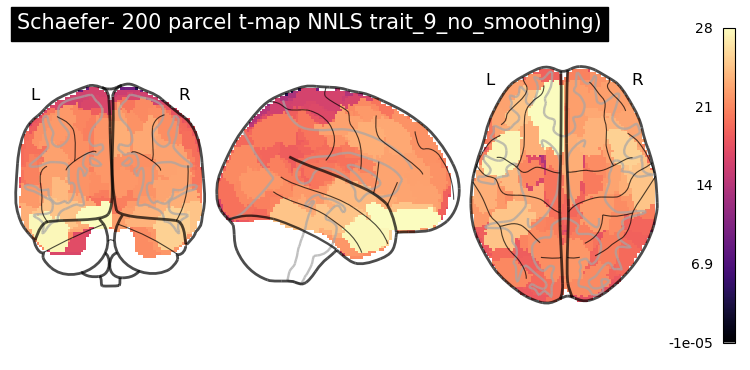

In [13]:
# ─── PARAMETERS ───────────────────────────────────────────────────────────
n_rois = 200
yeo_networks = 17
resolution_mm = 2
# fdr_alpha = 0.05     # threshold for p_fdr

# input CSV from group‐level t-test against F=1
group_csv = f"/Volumes/Passport/fmriprep/derivatives/RSA_stats/pieman/multi_regression/group_results/group_F1_stats_with_FDR_NNLS_{model_key}{smoothing_setting}.csv"

# output map filename
out_nii  = f"{n_rois}_parcel_t_map_NNLS_{model_key}{smoothing_setting}.nii.gz"

# ─── 1) LOAD & THRESHOLD ─────────────────────────────────────────────────
gr = pd.read_csv(group_csv)
# grab the full list of t‐stats in parcel order
t_values = gr.sort_values("parcel_num")["t_stat"].tolist()
# threshold down to only the significant parcels
# thr = gr[gr["p_fdr"] < fdr_alpha]

# ─── 2) FETCH THE SCHAEFER ATLAS ─────────────────────────────────────
schaefer   = datasets.fetch_atlas_schaefer_2018(
    n_rois=n_rois,
    yeo_networks=yeo_networks,
    resolution_mm=resolution_mm
)
atlas_img  = nib.load(schaefer["maps"])
atlas_data = atlas_img.get_fdata().astype(int)

# sanity check
assert atlas_data.max() == n_rois

# ─── 3) BUILD THE 3D T-STAT MAP ──────────────────────────────────────────
t_map = np.zeros_like(atlas_data, dtype=float)
for _, row in gr.iterrows():
    pid    = int(row["parcel_num"])
    tstat  = float(row["t_stat"])
    t_map[atlas_data == pid] = tstat

# ─── 4) SAVE OUT NIfTI ───────────────────────────────────────────────────
out_dir = os.path.join(
    deriv_dir,
    "RSA_stats",
    STIMULUS_LABEL_SAVE_STRING,   # no {…}
    "multi_regression",           # no {…}
)
os.makedirs(out_dir, exist_ok=True)

out_nii = os.path.join(
    out_dir,
    f"{n_rois}parcel_t_map_NNLS_{model_key}{smoothing_setting}.nii.gz"
)
new_img = nib.Nifti1Image(t_map, atlas_img.affine, atlas_img.header)
nib.save(new_img, out_nii)
print("✅ Saved thresholded t-map →", out_nii)

# ─── 5) PLOT (GLASS BRAIN) ────────────────────────────────────────────────
plotting.plot_glass_brain(
    out_nii,
    # threshold =5.0,      # set t threshold for more or less conservative display
    cmap="magma",
    colorbar=True,
    title=f"Schaefer- {n_rois} parcel t-map NNLS {model_key}{smoothing_setting})"
)
plotting.show() 

In [14]:
import nibabel as nib
import numpy as np
from nilearn.image import resample_to_img

# atlases you already loaded
atlas_res = resample_to_img(atlas_img, bold_img, interpolation="nearest")
atlas_data = atlas_res.get_fdata()

parcel_id = 173            # pick any ID you want to sanity-check
mask      = (atlas_data == parcel_id).astype(np.uint8)

mask_img = nib.Nifti1Image(mask, atlas_res.affine, atlas_res.header)
nib.save(mask_img, f"parcel_{parcel_id}_mask.nii.gz")
print("mask saved → parcel_173_mask.nii.gz")

mask saved → parcel_173_mask.nii.gz
